In [ ]:
%matplotlib inline


# Utilities for reading h5USID files

**Suhas Somnath**

4/18/2018

**This document illustrates the many handy functions in sidpy.hdf.hdf_utils and pyUSID.hdf_utils that significantly simplify reading data
and metadata in Universal Spectroscopy and Imaging Data (USID) HDF5 files (h5USID files)**


<span style="color:red">**Note**: Most of the functions demonstrated in this notebook have been moved out of ``pyUSID.hdf_utils`` and into ``sidpy.hdf``</span>
<br>

## Introduction
The USID model uses a data-centric approach to data analysis and processing meaning that results from all data analysis
and processing are written to the same h5 file that contains the recorded measurements. **Hierarchical Data Format
(HDF5)** files allow data, whether it is raw measured data or results of analysis, to be stored in multiple datasets within
the same file in a tree-like manner. Certain rules and considerations have been made in pyUSID to ensure
consistent and easy access to any data.

The h5py python package provides great functions to create, read, and manage data in HDF5 files. In
``pyUSID.hdf_utils``, we have added functions that facilitate scientifically relevant, or USID specific
functionality such as checking if a dataset is a Main dataset, reshaping to / from the original N dimensional form of
the data, etc. Due to the wide breadth of the functions in ``hdf_utils``, the guide for hdf_utils will be split in two
parts - one that focuses on functions that facilitate reading and one that facilitate writing of data. The following
guide provides examples of how, and more importantly when, to use functions in ``pyUSID.hdf_utils`` for various
scenarios.

## Recommended pre-requisite reading
* [Universal Spectroscopic and Imaging Data (USID) model](https://pycroscopy.github.io/USID/usid_model.html)
* [Crash course on HDF5 and h5py](./h5py_primer.html)


## Import all necessary packages

Before we begin demonstrating the numerous functions in ``pyUSID.hdf_utils``, we need to import the necessary
packages. Here are a list of packages besides pyUSID that will be used in this example:

* ``h5py`` - to open and close the file
* ``wget`` - to download the example data file
* ``numpy`` - for numerical operations on arrays in memory
* ``matplotlib`` - basic visualization of data
* ``sidpy`` - basic scientific hdf5 capabilities

In [ ]:
from __future__ import print_function, division, unicode_literals
import os
# Warning package in case something goes wrong
from warnings import warn
import subprocess
import sys


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:

try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install(wget)
    import wget
import h5py
import numpy as np
import matplotlib.pyplot as plt

# import sidpy - supporting package for pyUSID:
try:
    import sidpy
except ImportError:
    warn('sidpy not found.  Will install with pip.')
    import pip
    install('sidpy')
    import sidpy

# Finally import pyUSID.
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

In order to demonstrate the many functions in hdf_utils, we will be using a h5USID file containing real
experimental data along with results from analyses on the measurement data

### This scientific dataset

For this example, we will be working with a **Band Excitation Polarization Switching (BEPS)** dataset acquired from
advanced atomic force microscopes. In the much simpler **Band Excitation (BE)** imaging datasets, a single spectrum is
acquired at each location in a two dimensional grid of spatial locations. Thus, BE imaging datasets have two
position dimensions (``X``, ``Y``) and one spectroscopic dimension (``Frequency`` - against which the spectrum is recorded).
The BEPS dataset used in this example has a spectrum for **each combination of** three other parameters (``DC offset``,
``Field``, and ``Cycle``). Thus, this dataset has three new spectral dimensions in addition to ``Frequency``. Hence,
this dataset becomes a 2+4 = **6 dimensional dataset**

### Load the dataset
First, let us download this file from the pyUSID Github project:



In [3]:
url = 'https://raw.githubusercontent.com/pycroscopy/pyUSID/master/data/BEPS_small.h5'
h5_path = 'temp.h5'
_ = wget.download(url, h5_path, bar=None)

print('Working on:\n' + h5_path)

Working on:
temp.h5


Next, lets open this HDF5 file in read-only mode. Note that opening the file does not cause the contents to be
automatically loaded to memory. Instead, we are presented with objects that refer to specific HDF5 datasets,
attributes or groups in the file



In [6]:
h5_path = 'temp.h5'
h5_f = h5py.File(h5_path, mode='r')

Here, ``h5_f`` is an active handle to the open file

## Inspect HDF5 contents

The file contents are stored in a tree structure, just like files on a contemporary computer. The file contains
groups (similar to file folders) and datasets (similar to spreadsheets).
There are several datasets in the file and these store:

* The actual measurement collected from the experiment
* Spatial location on the sample where each measurement was collected
* Information to support and explain the spectral data collected at each location
* Since the USID model stores results from processing and analyses performed on the data in the same h5USID file,
  these datasets and groups are present as well
* Any other relevant ancillary information

### print_tree()
Soon after opening any file, it is often of interest to list the contents of the file. While one can use the open
source software HDFViewer developed by the HDF organization, ``pyUSID.hdf_utils`` also has a very handy function -
``print_tree()`` to quickly visualize all the datasets and groups within the file within python.



In [7]:
print('Contents of the H5 file:')
sidpy.hdf_utils.print_tree(h5_f)

Contents of the H5 file:
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices


By default, ``print_tree()`` presents a clean tree view of the contents of the group. In this mode, only the group names
are underlined. Alternatively, it can print the full paths of each dataset and group, with respect to the group / file
of interest, by setting the ``rel_paths``
keyword argument. ``print_tree()`` could also be used to display the contents of and HDF5 group instead of complete HDF5
file as we have done above. Lets configure it to print the relative paths of all objects within the ``Channel_000``
group:



In [8]:
sidpy.hdf_utils.print_tree(h5_f['/Measurement_000/Channel_000/'], rel_paths=True)

/Measurement_000/Channel_000
Bin_FFT
Bin_Frequencies
Bin_Indices
Bin_Step
Bin_Wfm_Type
Excitation_Waveform
Noise_Floor
Position_Indices
Position_Values
Raw_Data
Raw_Data-SHO_Fit_000
Raw_Data-SHO_Fit_000/Fit
Raw_Data-SHO_Fit_000/Guess
Raw_Data-SHO_Fit_000/Spectroscopic_Indices
Raw_Data-SHO_Fit_000/Spectroscopic_Values
Spatially_Averaged_Plot_Group_000
Spatially_Averaged_Plot_Group_000/Bin_Frequencies
Spatially_Averaged_Plot_Group_000/Mean_Spectrogram
Spatially_Averaged_Plot_Group_000/Spectroscopic_Parameter
Spatially_Averaged_Plot_Group_000/Step_Averaged_Response
Spatially_Averaged_Plot_Group_001
Spatially_Averaged_Plot_Group_001/Bin_Frequencies
Spatially_Averaged_Plot_Group_001/Mean_Spectrogram
Spatially_Averaged_Plot_Group_001/Spectroscopic_Parameter
Spatially_Averaged_Plot_Group_001/Step_Averaged_Response
Spectroscopic_Indices
Spectroscopic_Values
UDVS
UDVS_Indices


Finally, ``print_tree()`` can also be configured to only print USID Main datasets besides Group objects using the ``main_dsets_only`` option. 

**Note**: only ``pyUSID`` has this capability unlike ``sidpy``:

In [9]:
usid.hdf_utils.print_tree(h5_f, main_dsets_only=True)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Guess
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------


## Accessing Attributes

HDF5 datasets and groups can also store metadata such as experimental parameters. These metadata can be text,
numbers, small lists of numbers or text etc. These metadata can be very important for understanding the datasets
and guide the analysis routines.

While one could use the basic ``h5py`` functionality to access attributes, one would encounter a lot of problems when
attempting to decode attributes whose values were strings or lists of strings due to some issues in ``h5py``. This problem
has been demonstrated in our `primer to HDF5 and h5py <./plot_h5py.html>`_. Instead of using the basic functionality of ``h5py``, we recommend always
using the functions in pyUSID that reliably and consistently work for any kind of attribute for any version of
python:

### get_attributes()

``get_attributes()`` is a very handy function that returns all or a specified set of attributes in an HDF5 object. If no
attributes are explicitly requested, all attributes in the object are returned:



In [10]:
for key, val in sidpy.hdf_utils.get_attributes(h5_f).items():
    print('{} : {}'.format(key, val))

current_position_x : 4
experiment_date : 26-Feb-2015 14:49:48
data_tool : be_analyzer
translator : ODF
project_name : Band Excitation
current_position_y : 4
experiment_unix_time : 1503428472.2374
sample_name : PZT
xcams_id : abc
user_name : John Doe
comments : Band Excitation data
Pycroscopy version : 0.0.a51
data_type : BEPSData
translate_date : 2017_08_22
project_id : CNMS_2015B_X0000
grid_size_y : 5
sample_description : Thin Film
instrument : cypher_west
grid_size_x : 5


``get_attributes()`` is also great for only getting selected attributes. For example, if we only cared about the user
and project related attributes, we could manually request for any that we wanted:



In [11]:
proj_attrs = sidpy.hdf_utils.get_attributes(h5_f, ['project_name', 'project_id', 'user_name'])
for key, val in proj_attrs.items():
    print('{} : {}'.format(key, val))

user_name : John Doe
project_name : Band Excitation
project_id : CNMS_2015B_X0000


### get_attr()

If we are sure that we only wanted a specific attribute, we could instead use ``get_attr()`` as:



In [12]:
print(sidpy.hdf_utils.get_attr(h5_f, 'user_name'))

John Doe


### check_for_matching_attrs()
Consider the scenario where we are have several HDF5 files or Groups or datasets and we wanted to check each one to
see if they have the certain metadata / attributes. ``check_for_matching_attrs()`` is one very handy function that
simplifies the comparision operation.

For example, let us check if this file was authored by ``John Doe``:



In [14]:
print(sidpy.hdf.prov_utils.check_for_matching_attrs(h5_f, 
                                                    new_parms={'user_name': 'John Doe'}))

True


## Finding datasets and groups

There are numerous ways to search for and access datasets and groups in H5 files using the basic functionalities
of h5py. pyUSID.hdf_utils contains several functions that simplify common searching / lookup operations as part of
scientific workflows.

### find_dataset()

The ``find_dataset()`` function will return all datasets that whose names contain the provided string. In this case, we
are looking for any datasets containing the string ``UDVS`` in their names. If you look above, there are two datasets
(UDVS and UDVS_Indices) that match this condition:



In [15]:
udvs_dsets_2 = usid.hdf_utils.find_dataset(h5_f, 'UDVS')
for item in udvs_dsets_2:
    print(item)

<HDF5 dataset "UDVS": shape (256, 7), type "<f4">
<HDF5 dataset "UDVS_Indices": shape (22272,), type "<u8">


As you might know by now, h5USID files contain three kinds of datasets:

* ``Main`` datasets that contain data recorded / computed at multiple spatial locations.
* ``Ancillary`` datasets that support a main dataset
* Other datasets

For more information, please refer to the documentation on the USID model.

### check_if_main()
``check_if_main()`` is a very handy function that helps distinguish between ``Main`` datasets and other objects
(``Ancillary`` datasets, other datasets, Groups etc.). Lets apply this function to see which of the objects within the
``Channel_000`` Group are ``Main`` datasets:



In [16]:
h5_chan_group = h5_f['Measurement_000/Channel_000']

# We will prepare two lists - one of objects that are ``main`` and one of objects that are not

non_main_objs = []
main_objs = []
for key, val in h5_chan_group.items():
    if usid.hdf_utils.check_if_main(val):
        main_objs.append(key)
    else:
        non_main_objs.append(key)

# Now we simply print the names of the items in each list

print('Main Datasets:')
print('----------------')
for item in main_objs:
    print(item)
print('\nObjects that were not Main datasets:')
print('--------------------------------------')
for item in non_main_objs:
    print(item)

Main Datasets:
----------------
Raw_Data

Objects that were not Main datasets:
--------------------------------------
Bin_FFT
Bin_Frequencies
Bin_Indices
Bin_Step
Bin_Wfm_Type
Excitation_Waveform
Noise_Floor
Position_Indices
Position_Values
Raw_Data-SHO_Fit_000
Spatially_Averaged_Plot_Group_000
Spatially_Averaged_Plot_Group_001
Spectroscopic_Indices
Spectroscopic_Values
UDVS
UDVS_Indices


The above script allowed us to distinguish Main datasets from all other objects only within the Group named
``Channel_000``.

### get_all_main()
What if we want to quickly find all ``Main`` datasets even within the sub-Groups of ``Channel_000``? To do this, we have a
very handy function called - ``get_all_main()``:



In [17]:
main_dsets = usid.hdf_utils.get_all_main(h5_chan_group)
for dset in main_dsets:
    print(dset)
    print('--------------------------------------------------------------------')

<HDF5 dataset "Raw_Data": shape (25, 22272), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Cantilever Vertical Deflection (V) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 5 
	Y - size: 5 
Spectroscopic Dimensions: 
	Frequency - size: 87 
	DC_Offset - size: 64 
	Field - size: 2 
	Cycle - size: 2
Data Type:
	complex64
--------------------------------------------------------------------
<HDF5 dataset "Fit": shape (25, 256), type "|V20">
located at: 
	/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit 
Data contains: 
	SHO parameters (compound) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 5 
	Y - size: 5 
Spectroscopic Dimensions: 
	DC_Offset - size: 64 
	Field - size: 2 
	Cycle - size: 2
Data Fields:
	Phase [rad], R2 Criterion, Quality Factor, Amplitude [V], Frequency [Hz]
--------------------------------------------------------------------
<HDF5 dataset "Guess": shape (25, 256), type "|V20">
locate

The datasets above show that the file contains three main datasets. Two of these datasets are contained in a HDF5
Group called ``Raw_Data-SHO_Fit_000`` meaning that they are results of an operation called ``SHO_Fit`` performed on the
``Main`` dataset - ``Raw_Data``. The first of the three main datasets is indeed the ``Raw_Data`` dataset from which the
latter two datasets (``Fit`` and ``Guess``) were derived.

The USID model allows the same operation, such as ``SHO_Fit``, to be performed on the same dataset (``Raw_Data``),
multiple
times. Each time the operation is performed, a new HDF5 Group is created to hold the new results. Often, we may
want to perform a few operations such as:

* Find the (source / main) dataset from which certain results were derived
* Check if a particular operation was performed on a main dataset
* Find all groups corresponding to a particular operation (e.g. - ``SHO_Fit``) being applied to a Main dataset

``hdf_utils`` has a few handy functions for many of these use cases.

### find_results_groups()
First, lets show that ``find_results_groups()`` finds all Groups containing the results of a ``SHO_Fit`` operation applied
to ``Raw_Data``:



In [20]:
# First get the dataset corresponding to Raw_Data
h5_raw = h5_chan_group['Raw_Data']

operation = 'SHO_Fit'
print('Instances of operation "{}" applied to dataset named "{}":'.format(operation, h5_raw.name))
h5_sho_group_list = usid.hdf_utils.find_results_groups(h5_raw, operation)
print(h5_sho_group_list)

Instances of operation "SHO_Fit" applied to dataset named "/Measurement_000/Channel_000/Raw_Data":
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000" (4 members)>]


As expected, the ``SHO_Fit`` operation was performed on ``Raw_Data`` dataset only once, which is why
``find_results_groups()`` returned only one HDF5 Group - ``SHO_Fit_000``.

### check_for_old()

Often one may want to check if a certain operation was performed on a dataset with the very same parameters to
avoid recomputing the results. ``hdf_utils.check_for_old()`` is a very handy function that compares parameters (a
dictionary) for a new / potential operation against the metadata (attributes) stored in each existing results group
(HDF5 groups whose name starts with ``Raw_Data-SHO_Fit`` in this case). Before we demonstrate ``check_for_old()``, lets
take a look at the attributes stored in the existing results groups:



In [21]:
print('Parameters already used for computing SHO_Fit on Raw_Data in the file:')
for key, val in sidpy.hdf_utils.get_attributes(h5_chan_group['Raw_Data-SHO_Fit_000']).items():
    print('{} : {}'.format(key, val))

Parameters already used for computing SHO_Fit on Raw_Data in the file:
machine_id : mac109728.ornl.gov
timestamp : 2017_08_22-15_02_08
SHO_guess_method : pycroscopy BESHO
SHO_fit_method : pycroscopy BESHO


Now, let us check for existing results where the ``SHO_fit_method`` attribute matches an existing value and a new value:



In [22]:
print('Checking to see if SHO Fits have been computed on the raw dataset:')
print('\nUsing "pycroscopy BESHO":')
print(usid.hdf_utils.check_for_old(h5_raw, 'SHO_Fit',
                                 new_parms={'SHO_fit_method': 'pycroscopy BESHO'}))
print('\nUsing "alternate technique"')
print(usid.hdf_utils.check_for_old(h5_raw, 'SHO_Fit',
                                 new_parms={'SHO_fit_method': 'alternate technique'}))

Checking to see if SHO Fits have been computed on the raw dataset:

Using "pycroscopy BESHO":
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000" (4 members)>]

Using "alternate technique"
[]


Clearly, while find_results_groups() returned any and all groups corresponding to ``SHO_Fit`` being applied to
``Raw_Data``, ``check_for_old()`` only returned the group(s) where the operation was performed using the same specified
parameters (``sho_fit_method`` in this case).

Note that ``check_for_old()`` performs two operations - search for all groups with the matching nomenclature and then
compare the attributes. ``check_for_matching_attrs()`` is the handy function, that enables the latter operation of
comparing a giving dictionary of parameters against attributes in a given object.

### get_source_dataset()
``hdf_utils.get_source_dataset()`` is a very handy function for the inverse scenario where we are interested in finding
the source dataset from which the known result was derived:



In [23]:
h5_sho_group = h5_sho_group_list[0]
print('Datagroup containing the SHO fits:')
print(h5_sho_group)
print('\nDataset on which the SHO Fit was computed:')
h5_source_dset = usid.hdf_utils.get_source_dataset(h5_sho_group)
print(h5_source_dset)

Datagroup containing the SHO fits:
<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000" (4 members)>

Dataset on which the SHO Fit was computed:
<HDF5 dataset "Raw_Data": shape (25, 22272), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Cantilever Vertical Deflection (V) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 5 
	Y - size: 5 
Spectroscopic Dimensions: 
	Frequency - size: 87 
	DC_Offset - size: 64 
	Field - size: 2 
	Cycle - size: 2
Data Type:
	complex64


Since the source dataset is always a ``Main`` dataset, ``get_source_dataset()`` results a ``USIDataset`` object instead of
a regular ``HDF5 Dataset`` object.

Note that ``hdf_utils.get_source_dataset()`` and ``find_results_groups()`` rely on the USID rule that results of an
operation be stored in a Group named ``Source_Dataset_Name-Operation_Name_00x``.

### get_auxiliary_datasets()

The association of datasets and groups with one another provides a powerful mechanism for conveying (richer) information. One way to associate objects with each other is to store the reference of an object as an attribute of another. This is precisely the capability that is leveraged to turn Central datasets into USID Main Datasets or ``USIDatasets``. USIDatasets need to have four attributes that are references to the ``Position`` and ``Spectroscopic``
``ancillary`` datasets. Note, that USID does not restrict or preclude the storage of other relevant datasets as attributes of another dataset. For example, the ``Raw_Data`` dataset appears to contain several attributes whose keys / names match the names of datasets we see above and values all appear to be HDF5 object references:

In [24]:
for key, val in sidpy.hdf_utils.get_attributes(h5_raw).items():
    print('{} : {}'.format(key, val))

Bin_Frequencies : <HDF5 object reference>
Position_Indices : <HDF5 object reference>
Excitation_Waveform : <HDF5 object reference>
out_of_field_Plot_Group : <HDF5 region reference>
Bin_Indices : <HDF5 object reference>
Spectroscopic_Indices : <HDF5 object reference>
UDVS : <HDF5 object reference>
Bin_Wfm_Type : <HDF5 object reference>
units : V
Bin_Step : <HDF5 object reference>
Bin_FFT : <HDF5 object reference>
Spectroscopic_Values : <HDF5 object reference>
UDVS_Indices : <HDF5 object reference>
Position_Values : <HDF5 object reference>
in_field_Plot_Group : <HDF5 region reference>
Noise_Floor : <HDF5 object reference>
quantity : Cantilever Vertical Deflection


As the name suggests, these HDF5 object references are references or addresses to datasets located elsewhere in the
file. Conventionally, one would need to apply this reference to the file handle to get the actual HDF5 Dataset / Group
object.

``get_auxiliary_datasets()`` simplifies this process by directly retrieving the actual Dataset / Group associated with
the attribute. Thus, we would be able to get a reference to the ``Bin_Frequencies`` Dataset via:



In [25]:
h5_obj = sidpy.hdf_utils.get_auxiliary_datasets(h5_raw, 'Bin_Frequencies')[0]
print(h5_obj)
# Lets prove that this object is the same as the 'Bin_Frequencies' object that can be directly addressed:
print(h5_obj == h5_f['/Measurement_000/Channel_000/Bin_Frequencies'])

<HDF5 dataset "Bin_Frequencies": shape (87,), type "<f4">
True


## Accessing Ancillary Datasets
One of the major benefits of h5USID is its ability to handle large multidimensional datasets at ease. ``Ancillary``
datasets serve as the keys or legends for explaining the dimensionality, reshape-ability, etc. of a dataset. There are
several functions in hdf_utils that simplify many common operations on ancillary datasets.

Before we demonstrate the several useful functions in hdf_utils, lets access the position and spectroscopic ancillary
datasets using the ``get_auxiliary_datasets()`` function we used above:



In [26]:
dset_list = sidpy.hdf_utils.get_auxiliary_datasets(h5_raw, ['Position_Indices', 'Position_Values',
                                                         'Spectroscopic_Indices', 'Spectroscopic_Values'])
h5_pos_inds, h5_pos_vals, h5_spec_inds, h5_spec_vals = dset_list

As mentioned above, this is indeed a six dimensional dataset with two position dimensions and four spectroscopic
dimensions. The ``Field`` and ``Cycle`` dimensions do not have any units since they are dimensionless unlike the other
dimensions.

### get_dimensionality()
Now lets find out the number of steps in each of those dimensions using another handy function called
``get_dimensionality()``:



In [27]:
pos_dim_sizes = usid.hdf_utils.get_dimensionality(h5_pos_inds)
spec_dim_sizes = usid.hdf_utils.get_dimensionality(h5_spec_inds)
pos_dim_names = sidpy.hdf_utils.get_attr(h5_pos_inds, 'labels')
spec_dim_names = sidpy.hdf_utils.get_attr(h5_spec_inds, 'labels')

print('Size of each Position dimension:')
for name, length in zip(pos_dim_names, pos_dim_sizes):
    print('{} : {}'.format(name, length))
print('\nSize of each Spectroscopic dimension:')
for name, length in zip(spec_dim_names, spec_dim_sizes):
    print('{} : {}'.format(name, length))

Size of each Position dimension:
X : 5
Y : 5

Size of each Spectroscopic dimension:
Frequency : 87
DC_Offset : 64
Field : 2
Cycle : 2


### get_sort_order()

In a few (rare) cases, the spectroscopic / position dimensions are not arranged in descending order of rate of change.
In other words, the dimensions in these ancillary matrices are not arranged from fastest-varying to slowest.
To account for such discrepancies, ``hdf_utils`` has a very handy function that goes through each of the columns or
rows in the ancillary indices matrices and finds the order in which these dimensions vary.

Below we illustrate an example of sorting the names of the spectroscopic dimensions from fastest to slowest in
the BEPS data file:



In [30]:
spec_sort_order = usid.hdf_utils.get_sort_order(h5_spec_inds)
print('Rate of change of spectroscopic dimensions: {}'.format(spec_sort_order))
print('\nSpectroscopic dimensions arranged as is:')
print(spec_dim_names)
sorted_spec_labels = np.array(spec_dim_names)[np.array(spec_sort_order)]
print('\nSpectroscopic dimensions arranged from fastest to slowest')
print(sorted_spec_labels)

Rate of change of spectroscopic dimensions: [0 2 1 3]

Spectroscopic dimensions arranged as is:
['Frequency' 'DC_Offset' 'Field' 'Cycle']

Spectroscopic dimensions arranged from fastest to slowest
['Frequency' 'Field' 'DC_Offset' 'Cycle']


### get_unit_values()

When visualizing the data it is essential to plot the data against appropriate values on the X, Y, or Z axes.
Recall that by definition that the values over which each dimension is varied, are repeated and tiled over the entire
position or spectroscopic dimension of the dataset. Thus, if we had just the bias waveform repeated over two cycles,
spectroscopic values would contain the bias waveform tiled twice and the cycle numbers repeated as many times as the
number of points in the bias waveform. Therefore, extracting the bias waveform or the cycle numbers from the ancillary
datasets is not trivial. This problem is especially challenging for multidimensional datasets such as the one under
consideration. Fortunately, ``hdf_utils`` has a very handy function for this as well:



In [31]:
pos_unit_values = usid.hdf_utils.get_unit_values(h5_pos_inds, h5_pos_vals)
print('Position unit values:')
for key, val in pos_unit_values.items():
    print('{} : {}'.format(key, val))
spec_unit_values = usid.hdf_utils.get_unit_values(h5_spec_inds, h5_spec_vals)

Position unit values:
Y : [0. 1. 2. 3. 4.]
X : [0. 1. 2. 3. 4.]


Since the spectroscopic dimensions are quite complicated, lets visualize the results from ``get_unit_values()``:



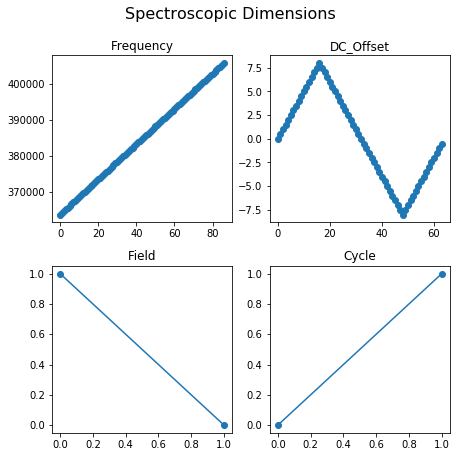

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6.5, 6))
for axis, name in zip(axes.flat, spec_dim_names):
    axis.set_title(name)
    axis.plot(spec_unit_values[name], 'o-')

fig.suptitle('Spectroscopic Dimensions', fontsize=16, y=1.05)
fig.tight_layout()

## Reshaping Data

### reshape_to_n_dims()

The USID model stores N dimensional datasets in a flattened 2D form of position x spectral values. It can become
challenging to retrieve the data in its original N-dimensional form, especially for multidimensional datasets such as
the one we are working on. Fortunately, all the information regarding the dimensionality of the dataset are contained
in the spectral and position ancillary datasets. ``reshape_to_n_dims()`` is a very useful function that can help
retrieve the N-dimensional form of the data using a simple function call:



In [35]:
ndim_form, success, labels = usid.hdf_utils.reshape_to_n_dims(h5_raw, get_labels=True)
if success:
    print('Succeeded in reshaping flattened 2D dataset to N dimensions')
    print('Shape of the data in its original 2D form')
    print(h5_raw.shape)
    print('Shape of the N dimensional form of the dataset:')
    print(ndim_form.shape)
    print('And these are the dimensions')
    print(labels)
else:
    print('Failed in reshaping the dataset')

Succeeded in reshaping flattened 2D dataset to N dimensions
Shape of the data in its original 2D form
(25, 22272)
Shape of the N dimensional form of the dataset:
(5, 5, 87, 64, 2, 2)
And these are the dimensions
['X' 'Y' 'Frequency' 'DC_Offset' 'Field' 'Cycle']


### reshape_from_n_dims()
The inverse problem of reshaping an N dimensional dataset back to a 2D dataset (let's say for the purposes of
multivariate analysis or storing into h5USID files) is also easily solved using another handy
function - ``reshape_from_n_dims()``:



In [36]:
two_dim_form, success = usid.hdf_utils.reshape_from_n_dims(ndim_form, h5_pos=h5_pos_inds, h5_spec=h5_spec_inds)
if success:
    print('Shape of flattened two dimensional form')
    print(two_dim_form.shape)
else:
    print('Failed in flattening the N dimensional dataset')

Shape of flattened two dimensional form
(25, 22272)


Close and delete the h5_file



In [ ]:
h5_f.close()
os.remove(h5_path)